In [1]:
# Install required packages
!pip install yfinance ta imbalanced-learn --quiet

In [56]:
# Import libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import ta
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Download NIFTY data
data = yf.download('NIFTYBEES.NS', start='2018-01-01', end='2024-12-31')
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] for col in data.columns]


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [14]:
# Add technical indicators
data['rsi'] = ta.momentum.RSIIndicator(close=data['Close']).rsi()
data['ema'] = ta.trend.EMAIndicator(close=data['Close'], window=14).ema_indicator()
data['macd'] = ta.trend.MACD(close=data['Close']).macd()
data['return'] = data['Close'].pct_change()
data['vol_change'] = data['Volume'].pct_change()
data['bb_width'] = ta.volatility.BollingerBands(close=data['Close']).bollinger_wband()
data['rsi_lag1'] = data['rsi'].shift(1)
data['macd_lag1'] = data['macd'].shift(1)
data['return_lag1'] = data['return'].shift(1)
data['stoch'] = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close']).stoch()
data['williams_r'] = ta.momentum.WilliamsRIndicator(data['High'], data['Low'], data['Close']).williams_r()
data['cci'] = ta.trend.CCIIndicator(data['High'], data['Low'], data['Close']).cci()
data['adx'] = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close']).adx()


In [20]:
data['stoch'] = ta.momentum.StochasticOscillator(
    high=data['High'], low=data['Low'], close=data['Close']).stoch()

data['williams_r'] = ta.momentum.WilliamsRIndicator(
    high=data['High'], low=data['Low'], close=data['Close']).williams_r()

data['cci'] = ta.trend.CCIIndicator(
    high=data['High'], low=data['Low'], close=data['Close']).cci()

data['adx'] = ta.trend.ADXIndicator(
    high=data['High'], low=data['Low'], close=data['Close']).adx()

In [21]:
# Target: 1 if next day's return > 0.7%,its marked as Buy(1) signal,otherwise 0.
data['Target'] = (data['Close'].pct_change().shift(-1) > 0.007).astype(int)
data.dropna(inplace=True)


In [22]:
# Feature and label setup,prepares the dataset for model training.
features = ['rsi', 'ema', 'macd', 'return', 'vol_change', 'bb_width', 'rsi_lag1', 'macd_lag1', 'return_lag1','stoch', 'williams_r', 'cci', 'adx']
X = data[features].astype(float)
y = data['Target'].astype(int)


In [23]:
# Splits the dataset into training and testing for evaluation,Also handles missing and infinite values.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]


In [24]:

# SMOTE balancing,This handles class imbalance by oversampling the minority class using SMOTE to improve model training.
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [25]:
# Train XGBoost model,its robust for tabular data and handles missing values well.
model = XGBClassifier(n_estimators=150, learning_rate=0.05, max_depth=4, scale_pos_weight=3, tree_method='hist')
model.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, ...)

In [26]:

# Predict probabilities on test set
probs = model.predict_proba(X_test)[:, 1]


In [57]:
# Find best threshold based on F1-score
thresholds = np.arange(0.05, 0.55, 0.01)
precisions = []
recalls = []
f1_scores = []
for t in thresholds:
    preds = (probs > t).astype(int)
      # Adjust to equal length
    min_len = min(len(y_test), len(preds))
    y_eval = y_test[:min_len]
    preds_eval = preds[:min_len]
    precisions.append(precision_score(y_eval, preds_eval))
    recalls.append(recall_score(y_eval, preds_eval))
    f1_scores.append(f1_score(y_eval, preds_eval))


    


In [58]:
#The best threscholds is applied,and predictions are alligned with the test set length.
preds = (probs > best_threshold).astype(int)

In [83]:
# Smooths the cloasing price using 5 day SMA,the calculates breturn and target based on that.
data['Close_SMA_5'] = data['Close'].rolling(window=5).mean()
data['return'] = data['Close_SMA_5'].pct_change()
data['Target'] = (data['Close_SMA_5'].pct_change().shift(-1) > 0.007).astype(int)

In [61]:
print(len(y_test), len(predictions))

335 335


In [62]:
min_len = min(len(y_test), len(predictions))
y_test = y_test[:min_len]
predictions = predictions[:min_len]

In [81]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

In [68]:
probs = model.predict_proba(X_test)[:, 1]
final_preds = (probs > best_threshold).astype(int)

In [82]:
print("Final Evaluation with Best Threshold:")
print(f"Accuracy: {accuracy_score(y_test, final_preds) * 100:.2f}%")
print(classification_report(y_test,final_preds))

Final Evaluation with Best Threshold:
Accuracy: 73.13%
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       285
           1       0.25      0.40      0.31        50

    accuracy                           0.73       335
   macro avg       0.57      0.59      0.57       335
weighted avg       0.79      0.73      0.75       335



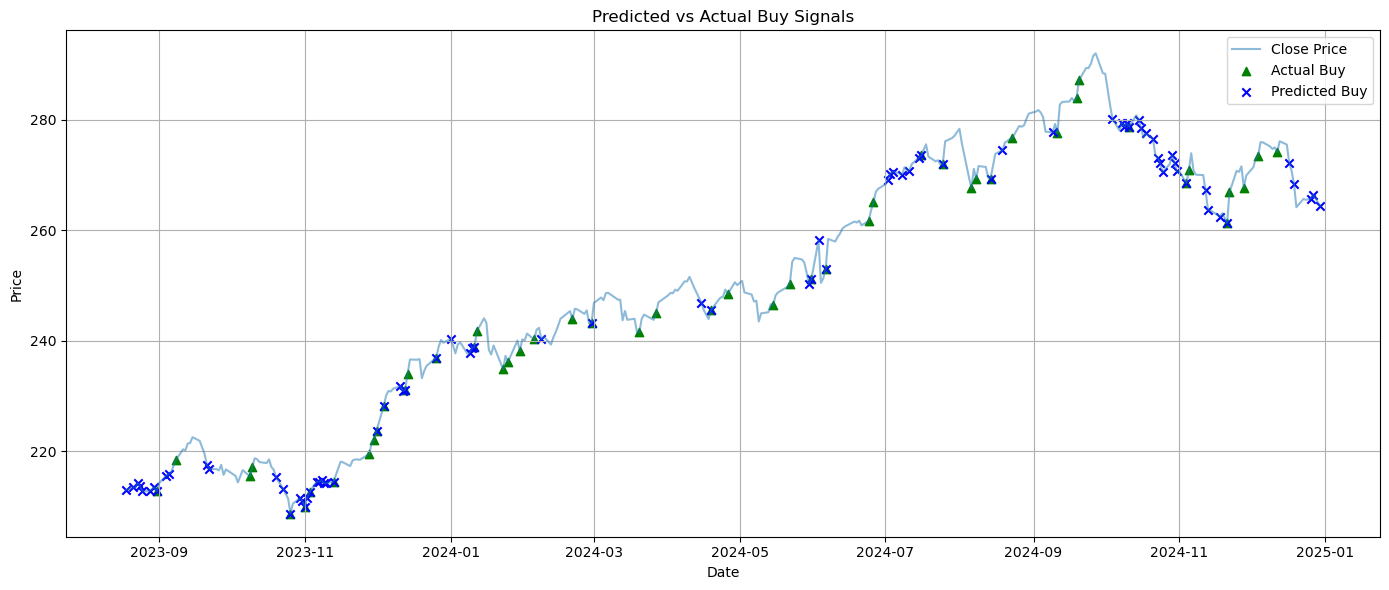

In [75]:
# Ensure X_test is a DataFrame with matching index to data
# And the test predictions align in index
test_indices = X_test.index

# Plot setup
plt.figure(figsize=(14, 6))

# Plot actual close prices
plt.plot(data.loc[test_indices]['Close'], label='Close Price', alpha=0.5)

# Plot actual buy signals (class 1 in y_test)
plt.scatter(data.loc[test_indices][y_test == 1].index,
            data.loc[test_indices][y_test == 1]['Close'],
            label='Actual Buy', marker='^', color='green')

# Plot predicted buy signals (class 1 in final_preds)
plt.scatter(data.loc[test_indices][final_preds == 1].index,
            data.loc[test_indices][final_preds == 1]['Close'],
            label='Predicted Buy', marker='x', color='blue')

# Labels and formatting
plt.title('Predicted vs Actual Buy Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [79]:
# Ensure index consistency
X_test = X_test.copy()
X_test['Actual'] = y_test
X_test['Predicted'] = final_preds
X_test['Close'] = data.loc[X_test.index, 'Close']  # or 'Close' if you renamed it

# Keep only the necessary columns
dashboard_df = X_test[['Close', 'Actual', 'Predicted']]

# Save to CSV
dashboard_df.to_csv('data_with_predictions.csv')
print("✅ Dashboard data saved to data_with_predictions.csv")

✅ Dashboard data saved to data_with_predictions.csv
